In [1]:
from datetime import datetime
from requests import get
from pandas import DataFrame
from pandas import to_numeric
from pandas import to_datetime
import numpy as np
from yfinance import Ticker
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
def get_data(exchange, symbol, interval):
    """
        this function received a exchange: String, symbol: String and return a matrix(n,n)
        ex:
        get_data('altilly', 'BTCUSDT', '30MIN')
            columuns:[timestamp, open, close, min, max, volume, volumeQuote]
        or
        ex:
        get_data('binance', 'BTCUSDT', '1m')
            columuns:[open, high, low, close, volume, close time, q_volume,
                      n_trades, base_volume, quote_volume]
        or
        ex:
        get_data('yahoo', '^BVSP', '1d')
            columns: [open, high, low, close, volume, dividends, stock_splits]
    """
    if exchange == 'altilly':
        uri = f'https://api.altilly.com/api/public/candles/{symbol}?limit=1000&period={interval}'
        r = get(uri).json()

        # limpeza
        df = DataFrame(r)
        for i in df.columns:
            if i == 'timestamp':
                df[i] = to_datetime(df[i])
            else:
                df[i] = to_numeric(df[i], errors='coerce')



        return df
    
    elif exchange == 'binance':
        url = 'https://api.binance.com/api/v3/klines?'
        payload = {'symbol': symbol, 'interval': interval, 'limit':1000}
        data = get(url, payload)
        df = DataFrame(data.json())
        df.columns = [
            'open time','open','high','low','close','volume','close time',
            'q_volume','n_trades','base_volume','quote_volume','ignore'
        ]  
        for i in df.columns:
            if 'time' in i:
                df[i] = df[i].apply(lambda x: (datetime.fromtimestamp(x/1000)))
            else:
                df[i] = to_numeric(df[i], errors='coerce')
        df = df.drop('open time', axis=1)
        df =  df.drop('ignore', axis=1)
        df.set_index(df['close time'], inplace=True)
        df =  df.drop('close time', axis=1)
        
        return df
    
    elif exchange == 'yahoo':
        df = Ticker(symbol)
        start_date, end_date = input('star_ex: 2020-1-30\n'), input('star_ex: 2020-2-30\n')
        df = df.history(period=interval, start=start_date, end=end_date)
        col = df.columns; df.columns = list(map(lambda x: x.lower(), col))
        
        return df

In [3]:
df = get_data('yahoo', '^BVSP', '1d')

star_ex: 2020-1-30
 2010-1-1
star_ex: 2020-2-30
 2020-7-25


In [4]:
df

,open,high,low,close,volume,dividends,stock splits
Date,,,,,,,
2010-01-04,68587.0,70081.0,68587.0,70045.0,1655400,0,0
2010-01-05,70046.0,70595.0,69928.0,70240.0,1984200,0,0
2010-01-06,70237.0,70937.0,70016.0,70729.0,2243600,0,0
2010-01-07,70723.0,70723.0,70045.0,70451.0,1555000,0,0
2010-01-08,70455.0,70766.0,70158.0,70263.0,1634400,0,0
...,...,...,...,...,...,...,...
2020-07-20,102888.0,104439.0,102744.0,104426.0,8931800,0,0
2020-07-21,104426.0,105449.0,103732.0,104310.0,11105800,0,0
2020-07-22,104312.0,104980.0,103277.0,104290.0,10833700,0,0


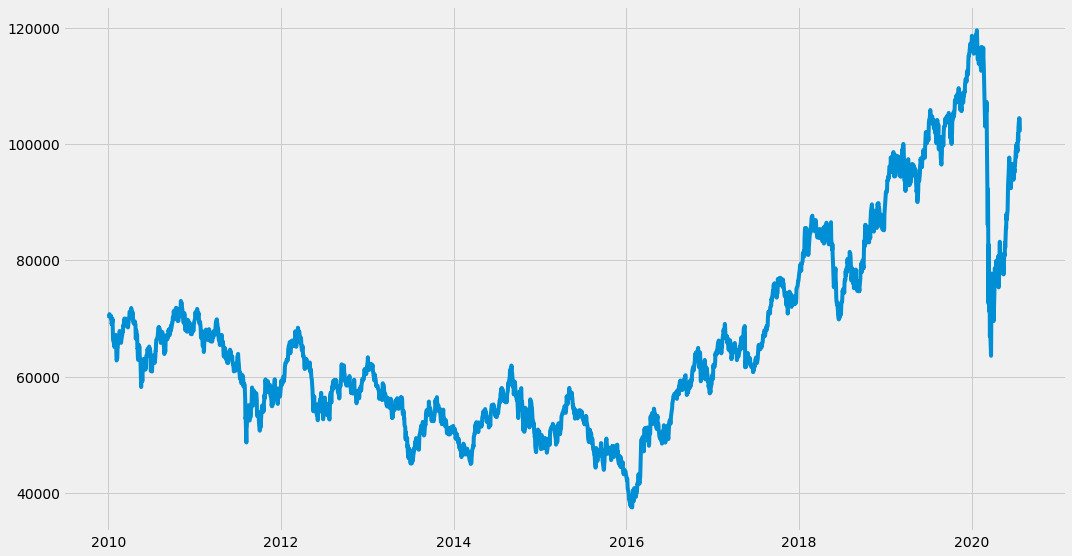

In [5]:
plt.figure(figsize=(16,9)); plt.plot(df['close']);

In [6]:
# new dataframe
data = df.filter(['close']); data_set = data.values

# tamnaho da base de treino
train_len = int(len(df.close) * .8)

# padronizando os dados entre 0 e 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_set)

# dados de traino 80%
train_data = scaled_data[0:train_len, :]

# dividindo os dados
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [7]:
# organizando os dados para "caber" no keras
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(x_train.shape)

(2027, 60)
(2027, 60, 1)


In [8]:
# construindo modelo LSTM
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=32))
model.add(Dense(units=32))
model.add(Dense(units=1))

# compilando modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# treinando modelo
model.fit(x_train, y_train, batch_size=64, epochs=32)

Epoch 1/32
32/32 [==============================] - 3s 97ms/step - loss: 3.3790e-04
Epoch 2/32
32/32 [==============================] - 3s 97ms/step - loss: 3.2353e-04
Epoch 3/32
32/32 [==============================] - 3s 97ms/step - loss: 3.2290e-04
Epoch 4/32
32/32 [==============================] - 3s 97ms/step - loss: 3.2836e-04
Epoch 5/32
32/32 [==============================] - 3s 96ms/step - loss: 3.0342e-04
Epoch 6/32
32/32 [==============================] - 3s 97ms/step - loss: 2.9238e-04
Epoch 7/32
32/32 [==============================] - 3s 96ms/step - loss: 2.8506e-04
Epoch 8/32
32/32 [==============================] - 3s 105ms/step - loss: 2.8021e-04
Epoch 9/32
32/32 [==============================] - 3s 97ms/step - loss: 2.7948e-04
Epoch 10/32
32/32 [==============================] - 3s 97ms/step - loss: 2.6910e-04
Epoch 11/32
32/32 [==============================] - 3s 97ms/step - loss: 2.6549e-04
Epoch 12/32
32/32 [==============================] - 3s 97ms/step - loss:

In [15]:
# modelando dados de teste
test_data = scaled_data[train_len - 60:, :]

x_test = []
y_test = data_set[train_len : , : ]

for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60 : i, 0])

x_test = np.array(x_test)

x_test =np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [16]:
# executando as predições
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [17]:
# calculando RMSE
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2050.826521922589

In [18]:
# plotando grafico da previção
train = data[:train_len]
valid = data[train_len:]
valid = DataFrame(valid, columns=['close', 'predict'])

In [19]:
valid.predict = predictions

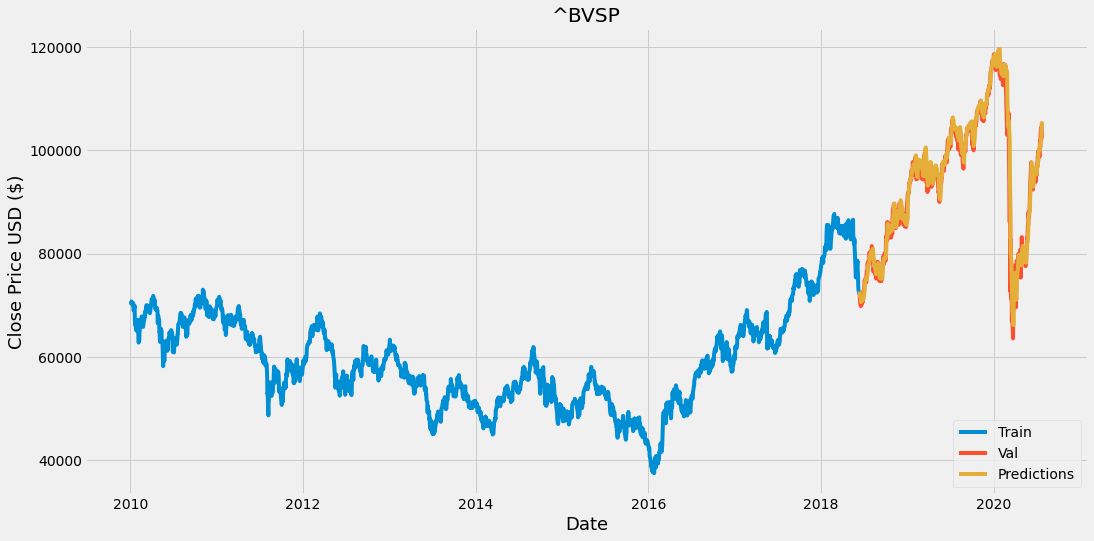

In [20]:
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('^BVSP')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'predict']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [21]:
valid

,close,predict
Date,,
2018-06-13,72122.0,72656.570312
2018-06-14,71421.0,72213.789062
2018-06-15,70758.0,71771.710938
2018-06-18,69815.0,71268.539062
2018-06-19,71394.0,70598.046875
...,...,...
2020-07-20,104426.0,102413.632812
2020-07-21,104310.0,103851.875000
2020-07-22,104290.0,104825.695312


In [22]:
# coletando dados
data = get_data('yahoo', '^BVSP',  '1d')

# criando novo dataset
new_df = df.filter(['close'])

# pegando os ultimos 60 dias
last_60 = new_df[-60:].values

# padronizando entre 0 e 1
last_60_scaled = scaler.transform(last_60)

# criando dados de teste
x_test = np.array(last_60_scaled)

star_ex: 2020-1-30
 2020-7-1
star_ex: 2020-2-30
 2020-7-24


In [23]:
# reshape pra "caber" no keras
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [32]:
# prevendo dados
pred_price = model.predict(x_test)

In [33]:
pred_price = scaler.inverse_transform(pred_price)

In [26]:
data = get_data('yahoo', '^BVSP',  '1d')

star_ex: 2020-1-30
 2020-7-1
star_ex: 2020-2-30
 2020-7-25


In [27]:
real = data.close.values[-1]

In [28]:
real

102382.0

In [29]:
predict = pred_price[-1].reshape(())

array([[56947.586],
       [56438.57 ],
       [56624.01 ],
       [56497.117],
       [56203.258],
       [56871.5  ],
       [56497.43 ],
       [56126.625],
       [56095.62 ],
       [56480.61 ],
       [56029.004],
       [57163.38 ],
       [57021.543],
       [57202.65 ],
       [57741.066],
       [57471.426],
       [58578.82 ],
       [58516.883],
       [59311.027],
       [58990.51 ],
       [59136.32 ],
       [59528.37 ],
       [60315.09 ],
       [60954.42 ],
       [61226.082],
       [61492.258],
       [62489.848],
       [62190.93 ],
       [61508.426],
       [60886.555],
       [60749.33 ],
       [61128.098],
       [61792.945],
       [61984.438],
       [62132.79 ],
       [61723.145],
       [61934.707],
       [61406.523],
       [61937.35 ],
       [61227.723],
       [61855.188],
       [61630.586],
       [62010.305],
       [62020.92 ],
       [62196.914],
       [62921.535],
       [62528.527],
       [63200.883],
       [62996.24 ],
       [63288.91 ],
